In [185]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from functools import partial, wraps 
import time
import random
    
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 
from InterObject import * 
from Global import * 
from Metrics import * 
from Tertiary import * 

load_dotenv("hidden.env") ## IMPORTANT: create a file (hidden.env) with your OpenAI API key 

True

## Set the Prompt 

In [186]:
scene_descriptor = "A bedroom that is 4m x 5m."

In [187]:
## Set up the API calls 
api_key = os.getenv('OPENAI_API_KEY')
client = openai.Client(api_key=api_key)
url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Authorization': f'Bearer {api_key}', 
    'Content-Type': 'application/json',
        }


# ## Read in all of the files to be used in the taskimport os
file_path1 = os.path.join("BlankConstraints", "Setup_Functions.py")
with open(file_path1, 'r') as file:
    file_contents1 = file.read()

file_path2 = os.path.join("BlankConstraints", "Individual.py")
with open(file_path2, 'r') as file:
    file_contents2 = file.read()

file_path3 = os.path.join("BlankConstraints", "InterObject.py")
with open(file_path3, 'r') as file:
    file_contents3 = file.read()

file_path4 = os.path.join("BlankConstraints", "Tertiary.py")
with open(file_path4, 'r') as file:
    file_contents4 = file.read()

def remove_identical_lines(function):
    lines = function.split("\n")
    unique_lines = []
    for i in range(len(lines)):

        line = lines[i]
        if line not in unique_lines: 
            unique_lines.append(line)
    return("\n").join(unique_lines)

def check_and_call(func_name, *args, **kwargs):
    """
    Calls the function with the given name if it exists in the global namespace.
    Returns the function's result or 0 if the function does not exist.
    """
    
    if func_name in globals() and callable(globals()[func_name]):
        return globals()[func_name](*args, **kwargs)
    else:
        return 0

def check_calls_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        return result
    return wrapper

def call_openai(prompt): 
    """Helper function to call OpenAI's API and return the response content."""
    # Define the request payload
    data = {
        "model": "gpt-4o",
        "messages": [{"role": "user", "content": prompt}]
        }
    # Make the API call
    response = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response.status_code == 200:
        response_data = response.json()
        if "```python" in response_data['choices'][0]['message']['content']:
            response = (response_data['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
        elif "```" in response_data['choices'][0]['message']['content']:
            response = (response_data['choices'][0]['message']['content'].split("```")[1]).split("```")[0]
        else: 
            response = response_data['choices'][0]['message']['content']
        return response
    else:
        print('Failed to get a response', response.text)
        return 
    


# Set up the Room (all dimensions + fixed features)

In [188]:
start_time = time.time() # Start the time

### Run the room set up calls (LangPrompt1, Prompt1)

In [189]:
lang_prompt1 = """ I am designing the layout for a """ +  scene_descriptor + """. Give me the dimensions of the room, as well as the number of windows, 
doors, and sockets (only add sockets and windows if its appropriate). For each of these, tell me the dimensions in meters, which wall it should be on, as well as where on the wall it should 
be (a value between 0 and 1 determining how far along the wall it should be). Here is an example for a room and window set up: 
{Room: width = 5, length = 6}, {Object type: window, width = 1, length = 0.1, wall = south, position = 3}. The windows and doors should all 
have length 0.1. Ensure that every object has dimensions, position, and wall. No other text please. Just the list with no commentary or explanation.
"""

lang1output = call_openai(lang_prompt1)
objects = lang1output.split("}, {") if lang1output else []


prompt1 = """The functions in the following file are used to create a room and out objects in it: """ + file_contents1 + """. The room is described 
as """ +  scene_descriptor + """. For every element in this list, """ + str(objects) + """, translate it into a function call using the file attached.
For example, given the room descriptor 'a small kitchen' as well as the list: {Room: width = 5, length = 6}, 
{Object type: window, Number: 1, width = 1, length = 0.1, wall = south, position = 0.3}, the output would be:
kitchen = create_room(5, 6), create_fixed_object(kitchen, 'window', 1, 0.1, 'south', position = 0.3). Return only the python script. 
No other text. Please ensure the correct number of inputs are given for each function."""


response1 = call_openai(prompt1)

## Account for any additional function calls (of other functions) by only taking the lines in the code that are relevant to the task   
lines = response1.split("\n")
response1 = [i for i in lines if 'create_room' in i]
## If the room is not defined properly, correct it
for line in response1: 
    if '=' not in line: 
        response1 = ['room = ' + line]
for line in lines[1:]: 
    if "create_fixed_object" in line: 
        response1.append(line)

response1 = ("\n").join(response1)

width = (response1.split("create_room("))[1].split(",")[0]
length = (response1.split("create_room("))[1].split(",")[1].split(")")[0]
room_name = (response1.split("create_room("))[0].split("=")[0].strip()

lang_prompt2 = """ I am designing the layout of a """ + scene_descriptor + " that is " + width + "m x " + length + """m. Interior designers
suggest that a good layout will have different regions in the room for different functions. What regions should I use, and how many regions 
(minimum is 1 region - small rooms, e.g. 3x3, 2x3, etc, should only have 1 region, small medium sized rooms will have 2, 3x4, 4x3, 4x4, medium will have 3, etc) 
should there be based on the description, as well as the size of the room. Make sure to not add too many regions as this causes overcrowding 
(very few rooms will have more than 4 regions). Return this as a simple bullet list of regions to 
include. Return these in list of priority order. Do NOT add too many regions.
Only return the list of regions. No other information please."""

lang2output = call_openai(lang_prompt2)

prompt2 = "Given the room name: " + room_name + ", and the regions: " + lang2output +  """, using the function region_setup defined below, 
initialise each region. For example 'eating region' might output 'region_setup(kitchen, 'eating', 0). Where possible the region name ('eating') should be 
only one word. No other text please, 
only the python script. Don't include the function in the output. The function is: 
def region_setup(room_name, name, index):
    '''A function that initialises the regions in a room randomly.
        Inputs:
        room_name: Room obj (this should be the name of the room)
        name: str, the name of the region e.g 'sleeping'
        index: int, the index of the region (0, 1, 2, ...). First one must be 0, and the rest must be in order.
    '''
    return
"""

response2 = call_openai(prompt2)
global_context = globals().copy()
local_context = {}  
exec(response1 + "\n" + response2.replace("'" + room_name + "'", room_name), global_context, local_context)

fixed_objects = ""
for i in range(len(local_context[room_name].fixed_objects)):
    if i < len(local_context[room_name].fixed_objects) - 1:
        fixed_objects +=local_context[room_name].fixed_objects[i].name + ", "
    else: 
        fixed_objects += local_context[room_name].fixed_objects[i].name + "."

region_names = ""
list_region_names = []
for i in range(len(local_context[room_name].regions)):
    if i < len(local_context[room_name].regions) - 1:
        region_names += local_context[room_name].regions[i].name + ", "
        list_region_names.append(local_context[room_name].regions[i].name)  
    else: 
        region_names += local_context[room_name].regions[i].name + "."
        list_region_names.append(local_context[room_name].regions[i].name)
num_primary_objects = len(list_region_names)
num_regions = len(list_region_names)

if "'" + room_name + "'" in response2:
    response2 = response2.replace("'" + room_name + "'", "local_context[room_name]")
elif '"' + room_name + '"' in response2:
    response2 = response2.replace('"' + room_name + '"', "local_context[room_name]")
else: 
    response2 = response2.replace(room_name, "local_context[room_name]")


In [190]:
print(response1)
print(list_region_names)

bedroom = create_room(4, 5)
create_fixed_object(bedroom, 'door', 0.9, 0.1, 'west', position=0.1)
create_fixed_object(bedroom, 'window', 1.2, 0.1, 'east', position=0.4)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'north', position=0.2)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'south', position=0.5)
['sleeping', 'storage', 'nook']


# Get the primary objects, as well as all of their constraints. 

In [191]:
lang_prompt3 = f"""The room is described as {scene_descriptor}. Now for each one of the regions: {region_names}, 
what is the most important object to include (keep in mind the room description), and what are its dimensions (give width of back of object and length of side of object but not height) 
in meters. ONLY one object per region. Don't include any objects that go on the walls, e.g. wall art, and don't include any rugs/mats. The size of the room is {width} m x {length}m, bear this in mind when choosing the objects and the size 
of the objects (i.e. put small objects in small rooms). Give no other information please."""

lang3output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt3}],
        max_tokens=2000
    )

print(lang3output.choices[0].message.content)

lang_prompt4 = f"""For each of these objects: {lang3output.choices[0].message.content}, tell me all of the considerations and constraints
for its placement within the room described as {scene_descriptor}, with size: {str(width)}m x {str(length)}m + room_width  that depend only on fixed features in the room like walls, windows, doors, sockets, etc. 
and return these as a bullet list for each object. Include practical things like whether it should be against a wall, or which side should be accessible for use 
(most objects will need an accessible constraint e.g. front of wardrobe needs to be accessible - however very few objects need all of their sides to be accessible 
and very few need their back to be accessible.) or if its tall, maybe it shouldn't block a window, etc. Bear in mind the size of the room, for example if the room is 
large, then the front, left, and right of the bed should be accessible, but if the room is very small, maybe only one side of the bed needs to be accessible.
Only give these constraints and considerations, no other information. """
 
lang4output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt4}],
        max_tokens=2000
    )

print(lang4output.choices[0].message.content)

lang_prompt5 = f"""Tell me all of the constraints and considerations between the objects in this list {lang3output.choices[0].message.content} that depend only on each other.
These objects are for different regions, so the constraints should only really be about them being away from each other or near each other, 
nothing more specific. For example, maybe a desk should not be close to a bed, etc. The room is described as {scene_descriptor}, with size: {str(width)} m x {str(length)} m
Only give the constraints and considerations between objects, no other information.."""

lang5output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt5}],
        max_tokens=2000
    )

print(lang5output.choices[0].message.content)

Sleeping: Bed - 1.5m x 2m  
Storage: Wardrobe - 1m x 0.6m  
Nook: Armchair - 0.8m x 0.8m
**Sleeping: Bed (1.5m x 2m)**
- Place against a wall to maximize floor space.
- Ensure at least one side is accessible for ease of getting in and out.
- Consider placing the head of the bed against a solid wall rather than under a window for better comfort and insulation.
- Avoid blocking heating vents.
- Ensure there is enough space to open any windows if bed is placed near one.

**Storage: Wardrobe (1m x 0.6m)**
- Front of the wardrobe must be accessible for opening and closing doors.
- Ideally placed against a wall to save space.
- Avoid blocking any windows.
- Ensure it does not block any heating vents.
- Place in an area where it won't obstruct walking paths.

**Nook: Armchair (0.8m x 0.8m)**
- Place against a wall or in a corner to maximize open space.
- Ensure the front is accessible for sitting down.
- Avoid blocking windows where natural light might be desired.
- Make sure it doesn't obstr

# Get the Secondary objects, as well as all of their constraints

In [192]:
lang_prompt6 = f"""Given a room described as: {scene_descriptor}, with size:{str(width)}m x {str(length)} m with these regions within 
it: {region_names}, and these primary objects already in it: {lang3output.choices[0].message.content}, what other objects should be added in? 
Give me 0-3 objects per region (depending on the size of the room - fewer objects for smaller rooms, and more objects for larger room) that should be added 
into the room (so make sure they are the most appropriate/necessary objects for their regions). Ensure to add objects that are necessary,e.g. if there's a desk, always add a 
desk chair. Try not to give objects that are redundant, e.g. if there is a tv stand in the room, you don't need a media console.
Objects should be things like furniture or plants or other objects that sit on the floor.
For each one, make sure that they make sense to go into one of the regions, and tell me which region they should go into. There can be more than one of 
each object kind (eg. multiple dining chairs or multiple nightstands) so make sure to specify how many of each object. Make sure to also give the dimensions of every object in meters (width of the back 
of the object and length of the side of the object but NOT HEIGHT). Remove any objects that are not placed directly on the floor, e.g. table lamp,
and remove any objects that are mounted on the wall (e.g. paintings). Don't include rugs. 
Only give objects that get placed onto the floor. Give no other text in the response. 
Only the list of objects."""

lang6output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt6}],
        max_tokens=1000
    )

print(lang6output.choices[0].message.content)

lang_prompt7 = f"""For each of these objects {lang6output.choices[0].message.content}, tell me all of the considerations and constraints for its placement 
within the room that depends only on fixed features in the room like walls, windows, doors, sockets, etc. (return these as a bullet list for each object). 
Include practical things like whether it should be against a wall and what side of the object (one of: left, right, back, front) or if it should be
against a wall, or which side should be accessible for use (Most objects will have an accessible constraint -
 this would be something like the wardrobe needs to be accessible from the front so that the doors can open, or the bed needs to be accessible from the sides
 - but only give necessary accessible constraints. If an object can have its side against something, then don't say its side needs to be accessible 
 e.g. for a nightstand, etc). The room is described as {scene_descriptor}. Don't include any constraints that depend on other objects. 
 Only give these constraints and considerations, no other information. """
lang7output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt7}],
        max_tokens=2000
    )

print(lang7output.choices[0].message.content)

lang_prompt8 = f"""Tell me all of the constraints and considerations between the objects in this list {lang6output.choices[0].message.content} as well as 
in this list {lang3output.choices[0].message.content}. For example, a desk chair should have its front against the front of the desk, or the left side of one 
of the nightstands should be against the right side of the bed, etc.  Be specific with relationships between objects to include sides (one of: left, right, back, front) 
if appropriate, or minimum/maximum distances between objects etc. The room is described as {scene_descriptor}.
Only give the constraints and considerations between objects, no other information."""

lang8output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt8}],
        max_tokens=2000
    )

print(lang8output.choices[0].message.content)

```
Sleeping: Nightstand - 0.5m x 0.5m  
Sleeping: Nightstand - 0.5m x 0.5m  
Sleeping: Dresser - 1m x 0.5m  
Storage: Shoe rack - 0.8m x 0.3m  
Nook: Side table - 0.5m x 0.5m  
Nook: Floor lamp (considered as a floor object) - 0.3m x 0.3m  
```
### Sleeping: Nightstand - 0.5m x 0.5m  
- Place against a wall to save space, with the back against the wall.
- Ensure there is a wall socket nearby for any lamps or electronic devices.

### Sleeping: Nightstand - 0.5m x 0.5m  
- Place against a wall to save space, with the back against the wall.
- Ensure there is a wall socket nearby for any lamps or electronic devices.

### Sleeping: Dresser - 1m x 0.5m  
- Place against a wall, with the back against the wall.
- Ensure the front is accessible for opening drawers.

### Storage: Shoe rack - 0.8m x 0.3m  
- Place against a wall, with the back against the wall.
- Ensure the front is accessible for placing and removing shoes.

### Nook: Side table - 0.5m x 0.5m  
- Place against a wall or beside 

# Get the Tertiary Objects (Decorations!)

In [193]:
lang_prompt9 = f"""Given a room described as: {scene_descriptor}, with size: {str(width)} m x {str(length)} m with these regions within 
it: {region_names}, and these objects already in it: {lang3output.choices[0].message.content} {lang6output.choices[0].message.content}, 
suggest any rugs or other decorations or objects (these are things that go on top of other objects) that should be placed in the room.
For example, a tv to go on the tv unit, a painting above the bed, a table lamp on the nightstand, or a chandelier over the dining table, a 
computer to go on the desk, etc. Don't give any furniture or objects that go on the floor (other than rugs).
Everything should either go on the wall, on the ceiling, or on top of a piece of furniture. Don't include curtains.
Tell me the dimensions of the objects (width and length not height - in meters). If it is a wall object, its length should be 0.1m. 
Tell me how they should be placed (with respect to one object. e.g. painting should be placed near the dining table or lamp should 
be placed on a nightstand). Don't give too many objects and don't include multi-object objects e.g. gallery walls or shelves. """

lang9output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt9}],
        max_tokens=1000
    )

print(lang9output.choices[0].message.content)

Here's a list of suggested decorations and objects that can enhance the bedroom without cluttering the space:

1. **Wall Art**  
   * **Dimensions:** 1.2m x 0.1m  
   * **Placement:** Hang above the bed to create a focal point in the sleeping area.  

2. **Table Lamp**  
   * **Dimensions:** 0.3m x 0.3m  
   * **Placement:** Place one on each of the nightstands to provide task lighting and symmetry.  

3. **Decorative Vase**  
   * **Dimensions:** 0.2m x 0.2m  
   * **Placement:** Place on the dresser for a touch of elegance and to add some color.  

4. **Framed Photo**  
   * **Dimensions:** 0.3m x 0.1m  
   * **Placement:** On the side table in the nook area, adding a personal touch.  

5. **Hanging Pendant Light**  
   * **Dimensions:** 0.4m x 0.4m  
   * **Placement:** Hang over the nook area to create a cozy reading space.  

6. **Mirror**  
   * **Dimensions:** 0.8m x 0.1m  
   * **Placement:** Hang above the dresser to make the room feel larger and provide a space for dress-up. 

# Cleaning of the Constraints

In [194]:
cleaning_prompt1 = f"""I am going to give you a list of constraints. I want you to merge any similar constraints and also remove any duplicate constraints. 
Each constraint should be simplified, so that it is said in the most basic terms. I want you to remove any constraints that are contradictory e.g. should be near a window 
AND should be away from a window. If there is an "or" statement in the constraint, choose one of the options. Finally, each bullet constraint should only specify one constraint. For example if there is a bullet point that says and object should not block windows 
and doors, change this into 2 bullets - one for blocking doors, and one for blocking windows. Remove any constraints that have if statements, and any
that involve height. If there are constraints for objects to be accessible from all sides that are unnecessary, 
change them to be which sides you think ARE necessary. If there are constraints with "or" in them, choose between the options. 
Return the list of cleaned constraints. Here is the list of constraints: {lang4output.choices[0].message.content}"""

cleaning1output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": cleaning_prompt1}],
        max_tokens=2000
    )


cleaning_prompt2 = f"""I am going to give you a list of constraints. I want you to merge any similar constraints and also remove any duplicate constraints. 
Each constraint should be simplified, so that it is said in the most basic terms. I also want you to remove any constraints that are contradictory e.g. should be near a window 
AND should be away from a window.  If there is an "or" statement in the constraint, choose one of the options.Finally, each bullet constraint should only specify one constraint. For example if there is a bullet point that says and object should be away 
from windows and doors, change this into 2 bullets - one for away from doors, and one for away from windows. Remove any constraints that have if statements, and any 
that involve height. If there are constraints with "or" in them, choose between the options. 
Return the list of cleaned constraints. Here is the list of constraints:{lang5output.choices[0].message.content}"""

cleaning2output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": cleaning_prompt2}],
        max_tokens=2000
    )

cleaning_prompt3 = f"""I am going to give you a list of constraints. I want you to merge any similar constraints and also remove any duplicate constraints. 
Each constraint should be simplified, so that it is said in the most basic terms. I also want you to remove any constraints that are contradictory e.g. should be near a window 
AND should be away from a window. If there is an "or" statement in the constraint, choose one of the options. Finally, each bullet constraint should only specify one constraint. For example if there is a bullet point that says and object should be away 
from windows and doors, change this into 2 bullets - one for away from doors, and one for away from windows. Remove any constraints that have if statements, and any 
that involve height. If there are constraints for objects to be accessible from all sides that are unnecessary, 
change them to be which sides you think ARE necessary. If there are constraints with "or" in them, choose between the options. 
Return the list of cleaned constraints.  Here is the list of constraints: {lang7output.choices[0].message.content}"""

cleaning3output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": cleaning_prompt3}],
        max_tokens=2000
    )


cleaning_prompt4 = f"""I am going to give you a list of constraints. I want you to merge any similar constraints and also remove any duplicate constraints. 
Each constraint should be simplified, so that it is said in the most basic terms. I also want you to remove any constraints that are contradictory e.g. should be near a window 
AND should be away from a window.  If there is an "or" statement in the constraint, choose one of the options. Finally, each bullet constraint should only specify one constraint. For example if there is a bullet point that says and object should be away 
from windows and doors, change this into 2 bullets - one for away from doors, and one for away from windows. Remove any constraints that have if statements, and any 
that involve height. Return the list of cleaned constraints. If there are constraints with "or" in them, choose between the options. 
Here is the list of constraints: {lang8output.choices[0].message.content}"""

cleaning4output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": cleaning_prompt4}],
        max_tokens=2000
    )   


p_ind_cons = cleaning1output.choices[0].message.content
p_io_cons = cleaning2output.choices[0].message.content
s_ind_cons = cleaning3output.choices[0].message.content
s_io_cons = cleaning4output.choices[0].message.content

In [195]:
print(p_ind_cons)

Here is the cleaned list of constraints:

**Sleeping: Bed (1.5m x 2m)**
- Place against a solid wall.
- Ensure at least one side is accessible.
- Avoid blocking heating vents.
- Ensure enough space to open windows if nearby.

**Storage: Wardrobe (1m x 0.6m)**
- Ensure the front is accessible.
- Place against a wall.
- Avoid blocking windows.
- Avoid blocking heating vents.
- Do not obstruct walking paths.

**Nook: Armchair (0.8m x 0.8m)**
- Place against a wall or in a corner.
- Ensure the front is accessible.
- Avoid blocking windows.
- Do not obstruct pathways or doors.


In [196]:
print(p_io_cons)

Here is the cleaned and simplified list of constraints:

- Ensure adequate space between the bed and wardrobe for easy access.
- Place the armchair at a comfortable distance from the bed.
- Position the armchair to not block access to the wardrobe doors.
- Maintain clear pathways for movement around the room.


In [197]:
print(s_ind_cons)

### Sleeping: Nightstand - 0.5m x 0.5m  
- Place against a wall with the back against the wall.
- Ensure there is a nearby wall socket for lamps or electronic devices.

### Sleeping: Dresser - 1m x 0.5m  
- Place against a wall with the back against the wall.
- Ensure the front is accessible for opening drawers.

### Storage: Shoe rack - 0.8m x 0.3m  
- Place against a wall with the back against the wall.
- Ensure the front is accessible for placing and removing shoes.

### Nook: Side table - 0.5m x 0.5m  
- Place against a wall with the back against the wall.

### Nook: Floor lamp (considered as a floor object) - 0.3m x 0.3m  
- Place near a wall socket for power access.


In [198]:
print(s_io_cons)

Here is the cleaned list of constraints based on your requirements:

1. **Sleeping Area:**
   - One nightstand should be on the left side of the bed.
   - The other nightstand should be on the right side of the bed.
   - The bed's headboard should be against a wall.

2. **Storage Area:**
   - Dresser should have clearance space in front for drawers to open.
   - Wardrobe should have clearance in front for doors.
   - Shoe rack should be located near the wardrobe.

3. **Nook Area:**
   - Side table should be adjacent to the armchair.
   - Floor lamp should be positioned beside the armchair.

4. **General Considerations:**
   - Ensure adequate walking space throughout the room.
   - Maintain ergonomic spacing between furniture, with adequate clearance for movement.


# Add all the objects into the room 
### Region by region. 

In [199]:
prompt4 = f"""Given this list of primary objects: {lang3output.choices[0].message.content}, and this list of secondary objects: {lang6output.choices[0].message.content}, use the file attached to create the objects with the correct parameters.
The room name is: {room_name}, the region names are: {str(list_region_names)}. The room is already set up, only add in the objects using the 'create_moving_object' function. 
Ensure that each objects index is unique and that the indices begin from 0. The objects should be added in the correct regions. Add in all of the primary objects first.
This is the file: {file_contents1}. No extra text, only the function calls. Don't have 'python' at the start of the code. Do not define ANY functions, only call them."""

response4 = call_openai(prompt4)     
lines = response4.split("\n")
response4_1 = []
for line in lines: 
    if "create_moving_object" in line: 
        response4_1.append(line)
response4_1 = ("\n").join(response4_1)

response4_1 = response4_1.replace("create_moving_object(room,", "create_moving_object(" + room_name + ",")
response4 = remove_identical_lines(response4_1).replace("(" + room_name, "(local_context[room_name]")

strings = response4.split("create_moving_object(local_context[room_name],")
primary_objects = []
for string in strings[1:]:
    if "'" in string: 
        primary_objects.append(string.split("'")[1])
    else:
        primary_objects.append(string.split('"')[1])

print(response4)

create_moving_object(local_context[room_name], 'bed', 1.5, 2, 'sleeping', 0)
create_moving_object(local_context[room_name], 'wardrobe', 1, 0.6, 'storage', 1)
create_moving_object(local_context[room_name], 'armchair', 0.8, 0.8, 'nook', 2)
create_moving_object(local_context[room_name], 'nightstand', 0.5, 0.5, 'sleeping', 3)
create_moving_object(local_context[room_name], 'nightstand', 0.5, 0.5, 'sleeping', 4)
create_moving_object(local_context[room_name], 'dresser', 1, 0.5, 'sleeping', 5)
create_moving_object(local_context[room_name], 'shoe rack', 0.8, 0.3, 'storage', 6)
create_moving_object(local_context[room_name], 'side table', 0.5, 0.5, 'nook', 7)
create_moving_object(local_context[room_name], 'floor lamp', 0.3, 0.3, 'nook', 8)


In [200]:
object_creations = ['' for i in range(num_regions + 1)]
lines = response4.split("\n")
for i in range(num_regions):
    sub_lines = [line for line in lines if "'" + list_region_names[i] + "'," in line or  '"' + list_region_names[i] + '",' in line]
    object_creations[0] = "\n".join([object_creations[0], sub_lines[0]])
    object_creations[i + 1] = "\n".join(sub_lines[1:])

primary_objects = []
secondary_objects = []
primary_object_indices = []

for name in list_region_names:
    lines = [i for i in response4.split("\n") if ((name + "'," in i or name + '",' in i) and 'create_moving_object' in i)]
    if "'" in lines[0]: 
        name = lines[0].split("'")[1]
    else:
        name = lines[0].split('"')[1]
    index = int(lines[0].split(", ")[-1].split(")")[0])
    primary_object_indices += [index]
    primary_objects += [name]

    for line in lines[1:]:
        if "'" in line: 
            name = line.split("'")[1]
        else:
            name = line.split('"')[1]
        secondary_objects += [name]

secondary_object_indices = [i for i in range(len(secondary_objects) + len(primary_objects)) if i not in primary_object_indices]

In [201]:
print(primary_object_indices, secondary_object_indices)
print(primary_objects, secondary_objects)

[0, 1, 2] [3, 4, 5, 6, 7, 8]
['bed', 'wardrobe', 'armchair'] ['nightstand', 'nightstand', 'dresser', 'shoe rack', 'side table', 'floor lamp']


# Find the Primary Optimization Functions

In [202]:
indent = '    '

In [203]:
def get_primary_function_calls():

    prompt5 = f"""Given the room_name {room_name} as well as the primary objects: {str(primary_objects)}, their 
    indices {str(primary_object_indices)} and these constraints: {p_ind_cons}, using the script attached, transform each constraint into a SINGLE 
    function call that will ensure that the primary objects are set up correctly. Match each constraint to the closest function in the
    script file by using the docstrings. Ensure that every constraint is mapped to a function call. Here is the first script: {file_contents2}. 
    For the second script, I want you to transform each pairwise constraint into a function call.
    Here is the second script: {file_contents3}, and here is the list of pairwise constraints: {p_io_cons}. I want 
    the output to begin with: def optimize_primary_objects(positions, room): \n output = 0,  followed by each constraint function call added to the output, 
    and then the output returned (everyline should begin with 'output +=' except for the final line). Go object by object, and then pairwise. 
    No extra text please, only the functions and the output. If there is only 1 primary object, there should be no pairwise calls.
    Do not define ANY functions, only call them. ENSURE that all parameters match docstrings."""

    # Define the request payload
    data = {
        "model": "gpt-4o",
        "messages": [
                {"role": "user", "content": prompt5}
                ]
        }
        
    # Make the API call
    response5 = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response5.status_code == 200:
        response_data5 = response5.json()

        if "```" in response_data5['choices'][0]['message']['content']:
            list_objects = (response_data5['choices'][0]['message']['content']).split("\n")[1:-1]
            response5_1 = ""
            for i in range(len(list_objects)):
                response5_1 += list_objects[i] + "\n"
        else: 
            
            response5_1 = response_data5['choices'][0]['message']['content']

        response5 = remove_identical_lines(response5_1).replace("'''", "").replace("```", "")
        lines = response5.split("\n")
        new_lines = []
        for i in range(len(lines)): 
            if "ind_in_region" in lines[i]: 
                continue
            if "output" in lines[i]: 
                new_lines += [indent + "output" + lines[i].split("output")[1]]
                if '=' not in lines[i]: 
                    new_lines[-1] = indent + "\n"

            else: 
                new_lines += [lines[i]]
        
        response5 = ("\n").join(new_lines)
        whole_calls = [indent + "output += wall_attraction(positions, room)\n" + indent, "output += in_bounds(positions, room)\n" + indent, "output += no_overlap(positions, room)\n" + indent, "output += aligned(positions, room)\n" + indent, "output += 10*balanced(positions, room)\n" + indent + "return output"]
        new = response5.split("return")[0] 
        for call in whole_calls: 
            new += call 
        response5 = new

        lines = response5.split("\n")
        for line in lines[1:]: 
            if "ind_" in line or "io_" in line: 
                function_name = (line.split("(")[0]).split("= ")[1].strip()
                args = (line.split("(")[1]).split(")")[0]
                new_line = line.split("+=")[0] + " += check_and_call('" + function_name + "', " + args + ")"       
                lines[lines.index(line)] = new_line

        primary_function = ("\n").join(lines)
        print(primary_function)     
        
    else:
        print('Failed to get a response')
        primary_function = response5.text
    
    return primary_function

primary_function = get_primary_function_calls()
while ("ind_" not in primary_function or "io_" not in primary_function) and len(primary_object_indices) > 1:
    print("Failure to get individual AND inter object function calls. Rerunning.")
    primary_function = get_primary_function_calls()

def optimize_primary_objects(positions, room):
    output = 0

    # Sleeping: Bed constraints
    output  += check_and_call('ind_next_to_wall', positions, room, 0)
    output  += check_and_call('ind_accessible', positions, room, 0, sides=['left', 'right'])
    output  += check_and_call('ind_away_from_fixed_object', positions, room, 0, fixed_object_type='heating vent')
    output  += check_and_call('ind_not_block_fixed_object', positions, room, 0, fixed_object_type='window')
    # Storage: Wardrobe constraints
    output  += check_and_call('ind_next_to_wall', positions, room, 1)
    output  += check_and_call('ind_accessible', positions, room, 1, sides=['front'])
    output  += check_and_call('ind_not_block_fixed_object', positions, room, 1, fixed_object_type='window')
    output  += check_and_call('ind_away_from_fixed_object', positions, room, 1, fixed_object_type='heating vent')
    # Nook: Armchair constraints
    output  += check_and_call('ind_next_to_wall', positions, room, 2)
    

In [204]:
primary_accessible_constraints = []
lines = primary_function.split("\n")
for line in lines: 
    if "ind_accessible" in line: 
        primary_accessible_constraints.append("output" + line.split("output")[1])

# Get the Secondary Optimization Functions

In [205]:
objects_per_region =[[] for i in range(num_regions)]
lines = response4.split("\n")
for i in range(len(lines)):
    for j in range(num_regions):
        if list_region_names[j] + "'," in lines[i] or list_region_names[j] + '",' in lines[i]:
            object_index = int(lines[i].split(", ")[-1].split(")")[0])
            objects_per_region[j].append(object_index)
        
object_regions = [list_region_names[k] for k in range(num_regions) for i in objects_per_region[k][1:]]
obj_ind = [(secondary_objects[i], secondary_object_indices[i], object_regions[i]) for i in range(len(secondary_objects))]


In [206]:
def get_secondary_function_calls():
    prompt6 = f"""Given the primary objects: {str(primary_objects)} and their indices: {str(primary_object_indices)}, as well as the secondary
    objects, along with their indices and their regions: {str(obj_ind)},  their individual 
    constraints: {s_ind_cons}, and these are the region names: {region_names}.  Using the script attached, transform each constraint into a SINGLE 
    function call that will ensure that the primary objects are set up correctly. Match each constraint to the closest function in the
    script file by using the docstrings. Ensure that every constraint is mapped to a function call.
    Here is the first script: {file_contents2}. For the second script, I want you to transform each pairwise constraint into a SINGLE function call. 
    Here is the second script: {file_contents3}, and here is the list of pairwise constraints: {s_io_cons}. 
    I want the output to begin with: ’def optimize_secondary_objects(positions, room): \n output = 0\n’, followed by each constraint function call 
    added to the output, (each line should begin with 'output +='). Go object by object, and then pairwise. 
    Also ensure to use ind_in_region for each object. Do not define ANY functions, only call them. No extra text please, only the functions and the output."""

    # Define the request payload.
    data = {
        "model": "gpt-4o",
        "messages": [
                {"role": "user", "content": prompt6}
                ]
        }
        
    # Make the API call
    response6 = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response6.status_code == 200:

        if "```" in response6.json()['choices'][0]['message']['content']:
            list_objects = (response6.json()['choices'][0]['message']['content']).split("\n")[1:-1]
            response6_1 = ""
            for i in range(len(list_objects)):
                response6_1 += list_objects[i] + "\n"
        else: 
            
            response6_1 = response6.json()['choices'][0]['message']['content']
        
        indent1 = (response6_1.split("output")[0]).split("\n")[-1]

        response6 = "def optimize_secondary_objects(positions, room):\n" + indent + "output = 0\n"
        response6 += indent + "\n" + (("\n").join((response6_1.split("return")[0]).split("\n")[2:])).replace(indent1, indent) + "\n" + indent + "return output \n"

        whole_calls = ["output += wall_attraction(positions, room)\n" + indent, "output += in_bounds(positions, room)\n" + indent, "output += no_overlap(positions, room)\n" + indent, "output += aligned(positions, room)\n" + indent + "return"]
        new = response6.split("return")[0] 
        for call in whole_calls: 
            new += call 
        new += response6.split("return")[1]
        response6 = new

        lines = response6.split("\n")
        for line in lines[1:]: 
            if "ind_" in line or "io_" in line: 
                function_name = (line.split("(")[0]).split("= ")[1].strip()
                args = (line.split("(")[1]).split(")")[0]
                new_line = line.split("+=")[0] + " += check_and_call('" + function_name + "', " + args + ")"       
                lines[lines.index(line)] = new_line

        response6 = ("\n").join(lines)
        print(response6)

    else:
        print('Failed to get a response')
        response6 = response6.text

    return response6, indent1

response6, indent1 = get_secondary_function_calls()
while "ind_" not in response6:
    print("Failure to get individual function calls. Rerunning.")
    response6, indent1  = get_secondary_function_calls()
while "io_" not in response6:
    print("Failure to get Inter Object function calls. Rerunning.")
    response6, indent1  = get_secondary_function_calls()


def optimize_secondary_objects(positions, room):
    output = 0
    
    output  += check_and_call('ind_next_to_wall', positions, room, 3)
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 3, 'socket', side='back', max_dist=0.5)
    output  += check_and_call('ind_next_to_wall', positions, room, 4)
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 4, 'socket', side='back', max_dist=0.5)
    output  += check_and_call('ind_next_to_wall', positions, room, 5)
    output  += check_and_call('ind_accessible', positions, room, 5, sides=['front'], min_dist=0.5)
    output  += check_and_call('ind_next_to_wall', positions, room, 6)
    output  += check_and_call('ind_accessible', positions, room, 6, sides=['front'], min_dist=0.3)
    output  += check_and_call('ind_next_to_wall', positions, room, 7)
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 8, fixed_object_type='socket', side='back', max_dist=0.3)
    output  += ch

In [207]:
secondary_functions = ['' for i in range(num_regions)]
lines = response6.split("\n")

for i in range(num_regions - 1, -1, -1):
    function = ("\n").join(lines[:2]) + "\n" + indent
    function += ("\n" + indent).join(primary_accessible_constraints[:i + 1])
        

    for obj_index in objects_per_region[i]:
        for line in lines: 
            if " " + str(obj_index) + "," in line or " " + str(obj_index) + ")" in line: 
                if line not in function:
                    function += "\n" + line
            
    for line in lines: 
        if "no_overlap" in line:
            function += "\n" + line
        if "in_bounds" in line:
            function += "\n" + line
        if "aligned" in line: 
            function += "\n" + line
        if "return" in line: 
            function += "\n" + line

    secondary_functions[i] =  function

In [208]:
for i in secondary_functions: 
    print(i)

def optimize_secondary_objects(positions, room):
    output = 0
    output  += check_and_call('ind_accessible', positions, room, 0, sides=['left', 'right'])
    output  += check_and_call('io_next_to', positions, room, 3, 0, side1='right', side2='left')
    output  += check_and_call('io_next_to', positions, room, 4, 0, side1='left', side2='right')
    output  += check_and_call('ind_next_to_wall', positions, room, 0)
    output  += check_and_call('ind_next_to_wall', positions, room, 3)
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 3, 'socket', side='back', max_dist=0.5)
    output  += check_and_call('ind_in_region', positions, room, 3, 'sleeping', weight=5.0)
    output  += check_and_call('ind_next_to_wall', positions, room, 4)
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 4, 'socket', side='back', max_dist=0.5)
    output  += check_and_call('ind_in_region', positions, room, 4, 'sleeping', weight=5.0)
    output  += check_and_ca

In [209]:
new_secondary_functions = secondary_functions.copy()
secondary_accessible_constraints = [[] for i in range(num_regions)]
for region in range(num_regions):
    for i in secondary_functions[region].split("\n"):
        if "ind_accessible" in i:
            secondary_accessible_constraints[region].append(("output" + i.split("output")[1]).replace(indent1, indent))

    secondary_accessible_constraints[region] = "\n" +("\n").join(secondary_accessible_constraints[region])

for i in range(num_regions):
    if i > 0: 
        for j in secondary_accessible_constraints[i - 1].split("\n"):
            if j not in secondary_accessible_constraints[i]:
                secondary_accessible_constraints[i] += ("\n" + j).replace(indent1, indent)

secondary_functions = new_secondary_functions.copy()

## Get the Tertiary Object Function

In [210]:
prompt7 = f"""Given this list of tertiary objects: {lang9output.choices[0].message.content} use the function attached to create the objects with the correct parameters.
The room name is: {room_name}. The room description is: {scene_descriptor}. The room is already set up, only add in the objects using the 'create_tertiary_object' function.
Ensure that each objects index is unique and that the indices begin from 0. The object names should be simple and short. The objects should be given the correct tertiary type 
(ceiling, floor, wall, or table). Wall objects should all have length 0.1m. Ensure that th parameters are set correctly. This is the function: """ + """
def create_tertiary_object(room, name, width, length, tertiary, index):
        " A function that creates and places a tertiary object 
        Inputs:
        room: Room for the object to be put in
        name: str, name of the object all lowercase. E.g. 'painting'
        width: float, width of the object (m)
        length: float, length of the object (m)
        tertiary: str, tertiary object type, one of "wall" (for objects that go on the wall e.g. painting),
                 "floor" (for objects that go on the floor e.g. rug), "ceiling" (for objects that go on the ceiling e.g. chandelier), 
                 "table" (for objects that go on a table e.g. lamp). 
        index: int, index of the object in the room's tertiary object list
    " """ 
prompt7 += "No extra text, only the function calls. Don't have 'python' at the start of the code. Do not define ANY functions, only call them."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt7}
            ]
    }
    
# Make the API call
response7 = requests.post(url, headers=headers, json=data)  
# Check the response
if response7.status_code == 200:
    response_data7 = response7.json()


    if "```" in response_data7['choices'][0]['message']['content']:
        list_objects = (response_data7['choices'][0]['message']['content']).split("\n")[1:-1]
        response7_1 = ""
        for i in range(len(list_objects)):
            response7_1 += list_objects[i] + "\n"
     
    lines = response_data7['choices'][0]['message']['content'].split("\n")
    response7_1 = []
    for line in lines: 
        if "create_tertiary_object" in line: 
            response7_1.append(line)
    response7_1 = ("\n").join(response7_1)
    
    response7_1 = response7_1.replace("create_tertiary_object(room,", "create_tertiary_object(" + room_name + ",")
    if "'" + room_name + "'" in response7_1:
        response7 = remove_identical_lines(response7_1).replace("'" + room_name + "'", 'local_context[room_name]')
    elif '"' + room_name + '"' in response7_1:
        response7 = remove_identical_lines(response7_1).replace('"' + room_name + '"', 'local_context[room_name]')
    elif room_name in response7_1:
        response7 = remove_identical_lines(response7_1).replace("(" + room_name, '(local_context[room_name]')

else:
    print('Failed to get a response')
    print(response7.text)

tertiary_indices = [i for i in range(len(response7.split("\n")))]
tertiary_objects = []
lines = response7.split("\n")
for line in lines:
    if "'" in line: 
        tertiary_objects.append(line.split("'")[1])
    else:
        tertiary_objects.append(line.split('"')[1])

print(response7)

create_tertiary_object(local_context[room_name], "wall art", 1.2, 0.1, "wall", 0)  
create_tertiary_object(local_context[room_name], "table lamp", 0.3, 0.3, "table", 1)  
create_tertiary_object(local_context[room_name], "decorative vase", 0.2, 0.2, "table", 2)  
create_tertiary_object(local_context[room_name], "framed photo", 0.3, 0.1, "table", 3)  
create_tertiary_object(local_context[room_name], "pendant light", 0.4, 0.4, "ceiling", 4)  
create_tertiary_object(local_context[room_name], "mirror", 0.8, 0.1, "wall", 5)  


In [211]:
tertiary_objects = []
lines = response7.split("\n")
for line in lines: 
    if '"' in line: 
        tertiary_objects.append(line.split('"')[1])
    else: 
        tertiary_objects.append(line.split("'")[1])
print(tertiary_objects)

['wall art', 'table lamp', 'decorative vase', 'framed photo', 'pendant light', 'mirror']


In [212]:
def get_tertiary_function_calls():
    prompt8 = f"""Given all the objects in the room: {str(primary_objects)} {str(secondary_objects)} and their indices: {str(primary_object_indices)} {str(secondary_object_indices)}
    as well as the region names: {region_names}. Here are the tertiary objects and how they should be placed: {str(tertiary_objects)} {lang9output.choices[0].message.content}.
    These are there indices: {str(tertiary_indices)}. Using the script attached, transform each placement into a SINGLE function call that will ensure that 
    the tertiary objects are placed correctly. If there is not a function that fits, then choose another. 
    Here is the  script: {file_contents4}. I want the output to begin with: ’def optimize_tertiary_objects(positions, room): \n output = 0\n’, followed by each function call 
    added to the output, (each line should begin with 'output +='). Do not define ANY functions, only call them. No extra text please, 
    only the functions and the output."""

    # Define the request payload.
    data = {
        "model": "gpt-4o",
        "messages": [
                {"role": "user", "content": prompt8}
                ]
        }
        
    # Make the API call
    response8 = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response8.status_code == 200:

        if "```" in response8.json()['choices'][0]['message']['content']:
            list_objects = (response8.json()['choices'][0]['message']['content']).split("\n")[1:-1]
            response8_1 = ""
            for i in range(len(list_objects)):
                response8_1 += list_objects[i] + "\n"
        else: 
            
            response8_1 = response8.json()['choices'][0]['message']['content']
        
        indent1 = (response8_1.split("output")[0]).split("\n")[-1]

        response8 = "def optimize_tertiary_objects(positions, room):\n" + indent + "output = 0\n"
        response8 += indent + "\n" + (("\n").join((response8_1.split("return")[0]).split("\n")[2:])).replace(indent1, indent) + "\n" + indent + "return output \n"

        whole_calls = ["output += t_valid(positions, room)\n" + indent + "return"]
        new = response8.split("return")[0] 
        for call in whole_calls: 
            new += call 
        new += response8.split("return")[1]
        response8 = new

        lines = response8.split("\n")
        for line in lines[1:]: 
            if "positions" in line: 
                function_name = (line.split("(")[0]).split("= ")[1].strip()
                args = (line.split("(")[1]).split(")")[0]
                new_line = line.split("+=")[0] + " += check_and_call('" + function_name + "', " + args + ")"       
                lines[lines.index(line)] = new_line

        response8 = ("\n").join(lines)
        print(response8)

    else:
        print('Failed to get a response')
        response8 = response8.text

    return response8

response8 = get_tertiary_function_calls()
lines = response8.split("\n")
new_lines = []
for i in range(len(lines)): 
    if "output" in lines[i] or "def" in lines[i]: 
        new_lines.append(lines[i])
response8 = ("\n").join(new_lines)

def optimize_tertiary_objects(positions, room):
    output = 0
    
    output  += check_and_call('on_wall_in_region', positions, room, 0, 'sleeping')
    output  += check_and_call('on_top_central', positions, room, 1, 3)
    output  += check_and_call('on_top_central', positions, room, 1, 4)
    output  += check_and_call('on_top_central', positions, room, 2, 5)
    output  += check_and_call('on_top_central', positions, room, 3, 7)
    output  += check_and_call('ceiling_above', positions, room, 4, 2)
    output  += check_and_call('on_wall_in_region', positions, room, 5, 'storage')

    output  += check_and_call('t_valid', positions, room)
    return output 



In [213]:
print(lang9output.choices[0].message.content)

Here's a list of suggested decorations and objects that can enhance the bedroom without cluttering the space:

1. **Wall Art**  
   * **Dimensions:** 1.2m x 0.1m  
   * **Placement:** Hang above the bed to create a focal point in the sleeping area.  

2. **Table Lamp**  
   * **Dimensions:** 0.3m x 0.3m  
   * **Placement:** Place one on each of the nightstands to provide task lighting and symmetry.  

3. **Decorative Vase**  
   * **Dimensions:** 0.2m x 0.2m  
   * **Placement:** Place on the dresser for a touch of elegance and to add some color.  

4. **Framed Photo**  
   * **Dimensions:** 0.3m x 0.1m  
   * **Placement:** On the side table in the nook area, adding a personal touch.  

5. **Hanging Pendant Light**  
   * **Dimensions:** 0.4m x 0.4m  
   * **Placement:** Hang over the nook area to create a cozy reading space.  

6. **Mirror**  
   * **Dimensions:** 0.8m x 0.1m  
   * **Placement:** Hang above the dresser to make the room feel larger and provide a space for dress-up. 

In [214]:
lang_prompt10 = f"""Given the description of the room: {scene_descriptor}, with size: {str(width)}m x {str(length)}m 
with these objects within it: {str(primary_objects)} {str(secondary_objects)} {str(tertiary_objects)}, tell me the colours of the walls 
and whether there should be wallpaper/paint/some other wall material. Tell me the style and colour of the windows and doors. 
Tell me the material and colour of the floor, and for each object, one by one, describe its colour, style, etc. 
Make sure that all of the objects are cohesive together and match the description of the room."""


STYLEoutput = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt10}],
        max_tokens=4096
    )

In [215]:
print(STYLEoutput.choices[0].message.content)

Let's create a cohesive and visually appealing bedroom using all the objects and providing a detailed description that ties everything together.

### Walls
- **Color and Material:** A calming and neutral light beige paint with a matte finish will provide a warm and inviting ambiance without overwhelming the space. The ceiling could be kept a simple off-white for contrast. 
- **Alternative:** If you wish, one accent wall could feature a subtle textured wallpaper with a soft, understated botanical pattern in darker beige tones to add visual interest without clashing with the other elements.

### Windows and Doors
- **Windows:** Opt for large, simple white-framed windows with sheer, white curtains. The style could be modern with thin black rods to bring a hint of contrast. This style allows plenty of light, making the room feel more spacious.
- **Doors:** The door could be a classic, white-paneled style with a soft satin finish, maintaining the room's modern charm. 

### Floor
- **Materia

# Run the code !


Adding in the primary objects:  ['bed', 'wardrobe', 'armchair']


/opt/anaconda3/envs/flair/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Iteration: 0
Cost:  29.941647239039575 0.0955682690517006 0.7215366361408739
Iteration: 4 , New best result found. Cost:  5.714216937957904
Iteration: 7 , New best result found. Cost:  4.222595559558595
Iteration: 8 , New best result found. Cost:  4.186290810031794
Iteration: 30 , New best result found. Cost:  3.4864834336617894
Iteration: 50
Iteration: 100
Iteration: 150
Iteration: 194 , New best result found. Cost:  3.209447113426987
Iteration: 200
Iteration: 250
300


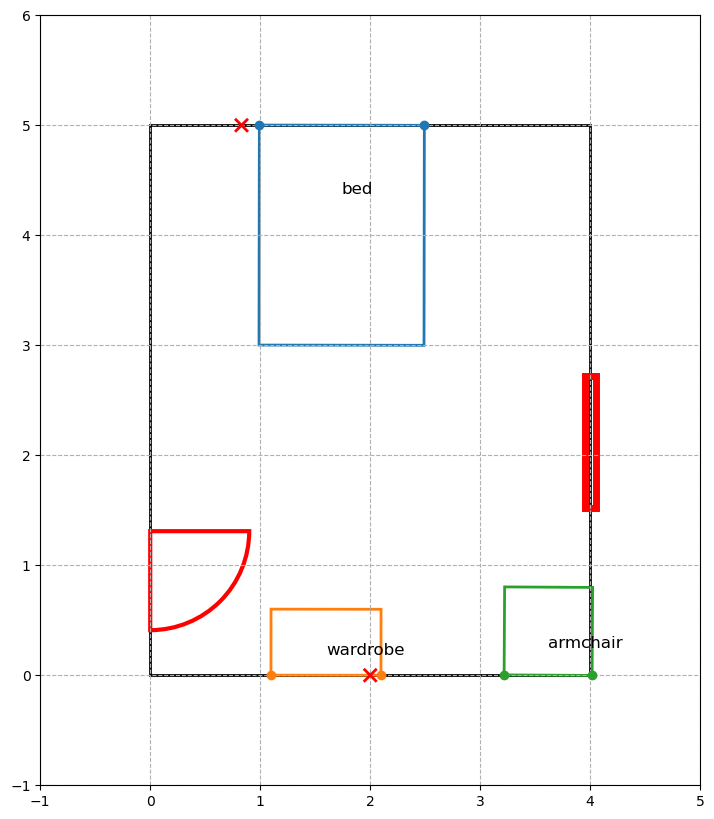

In [216]:
global_context = globals().copy()
local_context = {}
local_context2 = {}
exec(response1, global_context, local_context)

exec(primary_function, global_context, local_context) # define the very first optimizaton function 
## Now want to add in the first primary object
exec(response2) # add in the regions
exec(object_creations[0]) # add in the primary objecta
print("Adding in the primary objects: ", primary_objects)

options = {'maxiter': 200, 'ftol': 1e-6}
iters = 0
min_fun = np.inf
room = local_context[room_name]
func = local_context['optimize_primary_objects']
best_res = None
second_res = None
bounds = Bounds([-1, -1, -np.inf] * len(room.moving_objects), [room.width + 1, room.length + 1, np.inf] * len(room.moving_objects))
while min_fun > 1e-2 and iters < min(len(primary_objects)*100, 300):
    positions = np.zeros((len(room.moving_objects) - len(room.fm_indices)) * 3)
    for i in range(len(room.moving_objects) - len(room.fm_indices)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(func, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds) 

    if iters%50 == 0: 
        print("Iteration:", iters)
        if not best_res:
            print("Cost: ", res.fun, no_overlap(res.x, room), in_bounds(res.x, room))
    iters += 1
    if res.fun < min_fun:
        if not no_overlap(res.x, room) > 0.3 and not in_bounds(res.x, room) > 1e-2:
            min_fun = res.fun
            best_res = res
            print("Iteration:", iters, ", New best result found. Cost: ", min_fun)
    if not second_res:
        second_res = res
    elif second_res and ((res.fun <= second_res.fun) and (in_bounds(res.x, room) <= in_bounds(second_res.x, room) or no_overlap(res.x, room) <= no_overlap(second_res.x, room))): 
        second_res = res

print(iters)
if not best_res: 
    best_res = second_res

for i in range(len(room.fm_indices), len(room.moving_objects)): 
    j = i - len(room.fm_indices)
    room.moving_objects[i].position = (best_res.x[3*j], best_res.x[3*j + 1], best_res.x[3*j + 2]%(2*np.pi))
room.draw() 

for i in range(num_regions):
    room.regions[i].x, room.regions[i].y = room.moving_objects[i].position[0], room.moving_objects[i].position[1]


In [217]:
print(primary_function)

def optimize_primary_objects(positions, room):
    output = 0

    # Sleeping: Bed constraints
    output  += check_and_call('ind_next_to_wall', positions, room, 0)
    output  += check_and_call('ind_accessible', positions, room, 0, sides=['left', 'right'])
    output  += check_and_call('ind_away_from_fixed_object', positions, room, 0, fixed_object_type='heating vent')
    output  += check_and_call('ind_not_block_fixed_object', positions, room, 0, fixed_object_type='window')
    # Storage: Wardrobe constraints
    output  += check_and_call('ind_next_to_wall', positions, room, 1)
    output  += check_and_call('ind_accessible', positions, room, 1, sides=['front'])
    output  += check_and_call('ind_not_block_fixed_object', positions, room, 1, fixed_object_type='window')
    output  += check_and_call('ind_away_from_fixed_object', positions, room, 1, fixed_object_type='heating vent')
    # Nook: Armchair constraints
    output  += check_and_call('ind_next_to_wall', positions, room, 2)
    

In [218]:
for i in range(len(secondary_functions)):
    print(secondary_functions[i])

def optimize_secondary_objects(positions, room):
    output = 0
    output  += check_and_call('ind_accessible', positions, room, 0, sides=['left', 'right'])
    output  += check_and_call('io_next_to', positions, room, 3, 0, side1='right', side2='left')
    output  += check_and_call('io_next_to', positions, room, 4, 0, side1='left', side2='right')
    output  += check_and_call('ind_next_to_wall', positions, room, 0)
    output  += check_and_call('ind_next_to_wall', positions, room, 3)
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 3, 'socket', side='back', max_dist=0.5)
    output  += check_and_call('ind_in_region', positions, room, 3, 'sleeping', weight=5.0)
    output  += check_and_call('ind_next_to_wall', positions, room, 4)
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 4, 'socket', side='back', max_dist=0.5)
    output  += check_and_call('ind_in_region', positions, room, 4, 'sleeping', weight=5.0)
    output  += check_and_ca

Adding in the secondary objects:  ['nightstand', 'nightstand', 'dresser']
Iteration: 0
Cost:  12.031314943869582 3.746151675823725 0.7609739764728103
Iteration 26 , New best result found. Cost:  43.958433047666794 overlap:  0.18432700402010804 bounds:  0.03918529325463846


/opt/anaconda3/envs/flair/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


Iteration 36 , New best result found. Cost:  23.340915657240327 overlap:  0.17166816475970714 bounds:  0.007944131313263506
Iteration 38 , New best result found. Cost:  11.724694476268123 overlap:  0.06810036133998755 bounds:  0.016784775194661275
Iteration: 50
Iteration 75 , New best result found. Cost:  8.40491882090467 overlap:  0.17796760154693664 bounds:  0.00798825870937662
Iteration: 100


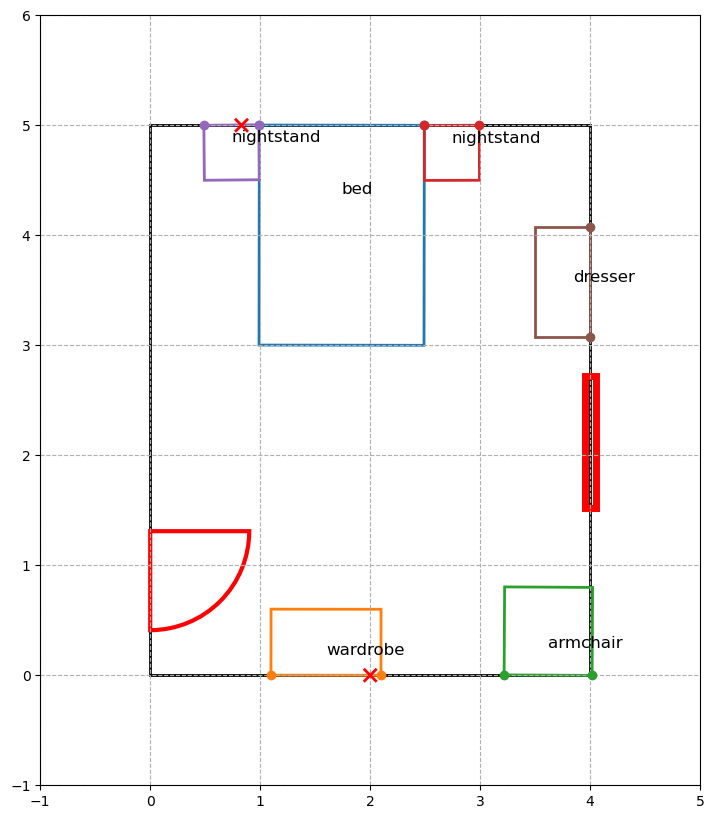

Adding in the secondary objects:  ['shoe rack']
Iteration: 0
Cost:  8.924712997328761 0.17796760154693664 1.8073220355390707
Iteration 2 , New best result found. Cost:  5.519074897490552 overlap:  0.17796760154693664 bounds:  0.007988258709377782
Iteration 6 , New best result found. Cost:  4.964151456270755 overlap:  0.17796760154693664 bounds:  0.007988258709377534
Iteration 9 , New best result found. Cost:  4.964151410092425 overlap:  0.17796760154693664 bounds:  0.00798825870937664
Iteration 15 , New best result found. Cost:  4.9641514060485425 overlap:  0.17796760154693664 bounds:  0.007988258709376623


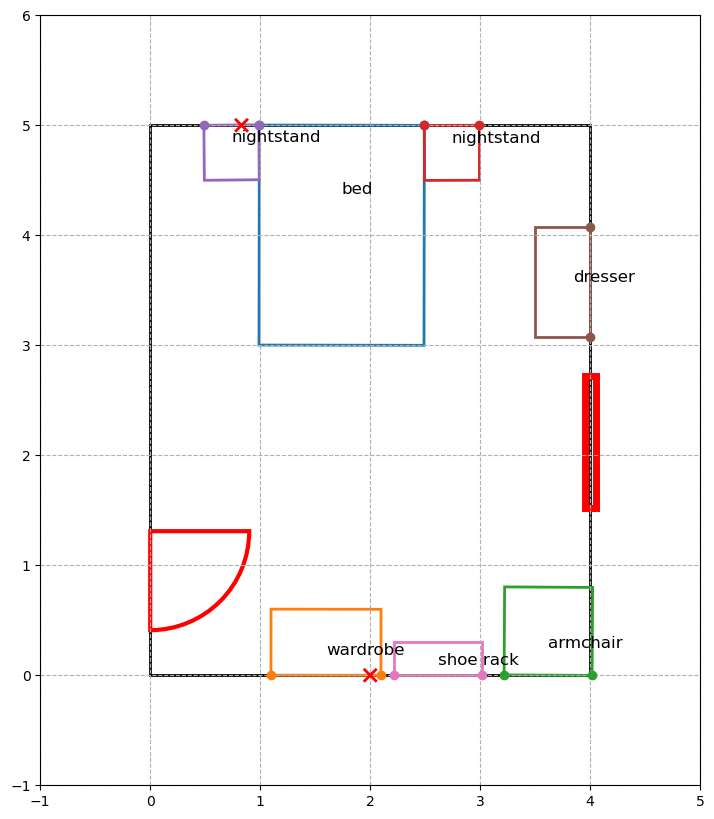

Adding in the secondary objects:  ['side table', 'floor lamp']
Iteration: 0
Cost:  10.709919769633084 2.6887600257971562 0.1964188974555791
Iteration 4 , New best result found. Cost:  13.337966851195475 overlap:  0.3159095559533148 bounds:  0.052543109128724286
Iteration 6 , New best result found. Cost:  9.422278043443292 overlap:  0.2858298799517133 bounds:  0.024629477297630695
Iteration 29 , New best result found. Cost:  9.422234257435356 overlap:  0.29044147606427734 bounds:  0.02338888584836995
Iteration 38 , New best result found. Cost:  9.422117221981791 overlap:  0.288701726551866 bounds:  0.023479533346772146
Iteration 46 , New best result found. Cost:  9.422112926656157 overlap:  0.28949567797983583 bounds:  0.023490455444900252
Iteration: 50
Iteration 68 , New best result found. Cost:  9.422111813203484 overlap:  0.2893589889346629 bounds:  0.023559821745856517


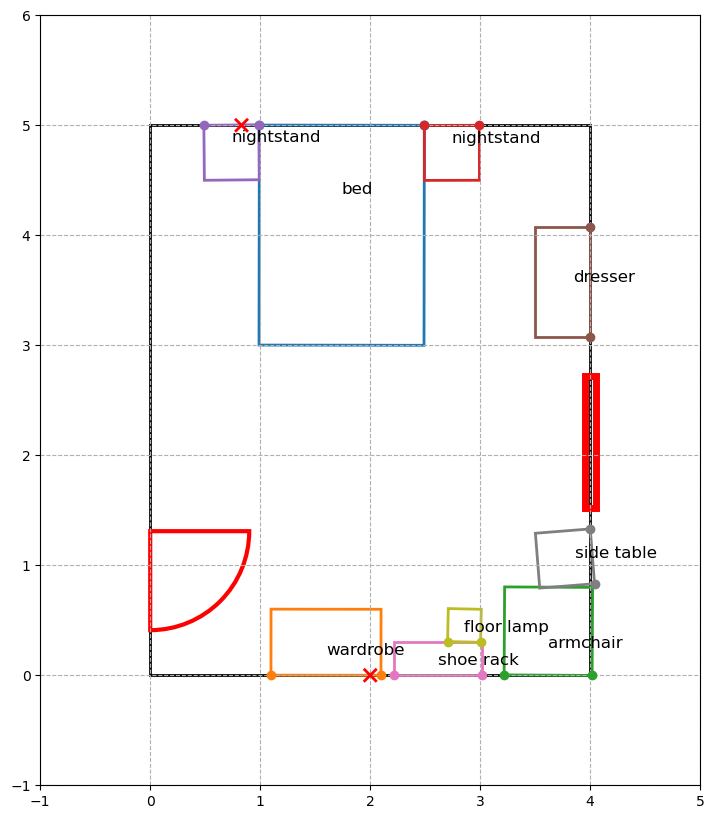

In [219]:
room.moving_objects = room.moving_objects[:num_primary_objects]
room.fm_indices = [i for i in range(num_primary_objects)]
room.tertiary_objects = []
options = {'maxiter': 200, 'ftol': 1e-8}

for region in range(num_regions):
    exec(object_creations[region + 1]) # add in the secondary objects for the region
    exec(secondary_functions[region], global_context, local_context) # define the optimization function for the secondary objects
    room = local_context[room_name]
    func = local_context['optimize_secondary_objects']
    
    print("Adding in the secondary objects: ", [room.moving_objects[i].name for i in objects_per_region[region]][1:])

    num = len(room.moving_objects) - len(room.fm_indices)
    bounds = Bounds([-1] * 3 * num, [room.width + 1, room.length + 1, np.inf] * num)
    iters = 0
    min_fun = np.inf
    best_res2 = None
    second_res = None
    while (min_fun > 1e-2 and best_res2 is None and iters < 400) or (best_res2 and iters < min(num*50, 300)):
        positions = np.zeros(3*num)
        for i in range(num):
            positions[3*i] = np.random.uniform(0, room.width)
            positions[3*i + 1] = np.random.uniform(0, room.length)
            positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
        res = minimize(func, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)

        if iters%50 == 0:
            print("Iteration:", iters)
            if not best_res2:
                print("Cost: ", res.fun, no_overlap(res.x, room), in_bounds(res.x, room))
        iters += 1
        if res.fun < min_fun:
            if not no_overlap(res.x, room) > 0.4 and not in_bounds(res.x, room) > 0.1:
                min_fun = res.fun 
                best_res2 = res
                print("Iteration", iters, ", New best result found. Cost: ", min_fun, "overlap: ", no_overlap(res.x, room), "bounds: ", in_bounds(res.x, room))
        if not second_res:
            second_res = res
        elif second_res and ((res.fun <= second_res.fun) and (in_bounds(res.x, room) <= in_bounds(second_res.x, room) or no_overlap(res.x, room) <= no_overlap(second_res.x, room))): 
            second_res = res
    
    if not best_res2: 
        best_res2 = second_res
  
    for i in range(len(room.fm_indices), len(room.moving_objects)): 
        j = i - len(room.fm_indices)
        room.moving_objects[i].position = (best_res2.x[3*j], best_res2.x[3*j + 1], best_res2.x[3*j + 2]%(2*np.pi))

    room.regions[region].x = np.mean([i.position[0] for i in room.moving_objects if i.region == list_region_names[region]])
    room.regions[region].y = np.mean([i.position[1] for i in room.moving_objects if i.region == list_region_names[region]])

    room.draw() 
    plt.show()
    room.fm_indices += [i for i in range(len(room.fm_indices), len(room.moving_objects))]


In [220]:
print(response7)
print(response8)

create_tertiary_object(local_context[room_name], "wall art", 1.2, 0.1, "wall", 0)  
create_tertiary_object(local_context[room_name], "table lamp", 0.3, 0.3, "table", 1)  
create_tertiary_object(local_context[room_name], "decorative vase", 0.2, 0.2, "table", 2)  
create_tertiary_object(local_context[room_name], "framed photo", 0.3, 0.1, "table", 3)  
create_tertiary_object(local_context[room_name], "pendant light", 0.4, 0.4, "ceiling", 4)  
create_tertiary_object(local_context[room_name], "mirror", 0.8, 0.1, "wall", 5)  
def optimize_tertiary_objects(positions, room):
    output = 0
    output  += check_and_call('on_wall_in_region', positions, room, 0, 'sleeping')
    output  += check_and_call('on_top_central', positions, room, 1, 3)
    output  += check_and_call('on_top_central', positions, room, 1, 4)
    output  += check_and_call('on_top_central', positions, room, 2, 5)
    output  += check_and_call('on_top_central', positions, room, 3, 7)
    output  += check_and_call('ceiling_above

Iteration 0 , New best result found. Cost:  16.66691591402566
Iteration 1 , New best result found. Cost:  2.0456287569536884
Iteration 4 , New best result found. Cost:  2.009674325316549
Iteration 10 , New best result found. Cost:  2.0096743253148888
Time taken:  688.5321102142334


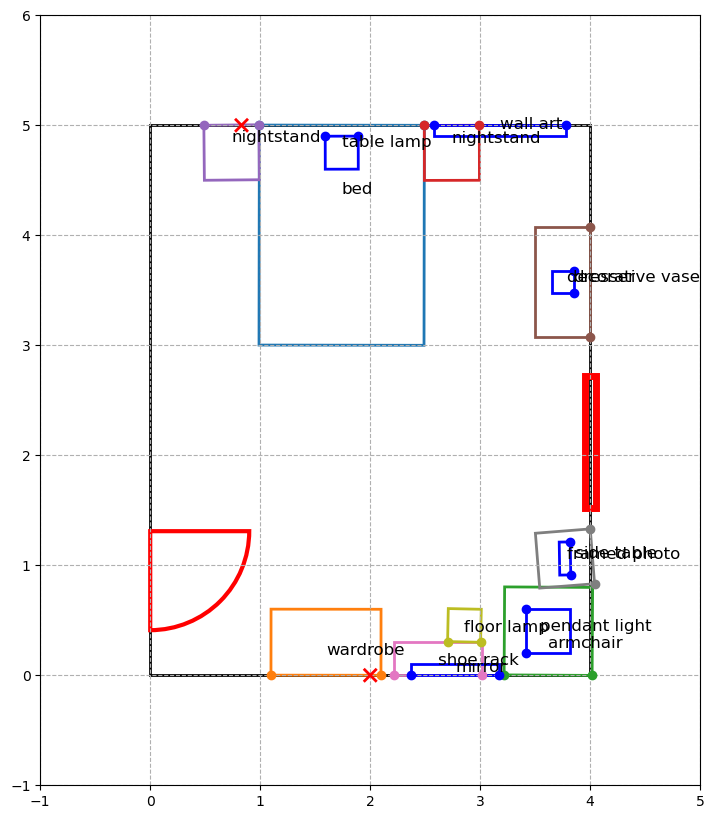

In [221]:
room.tertiary_objects = []
exec(response7)
exec(response8, global_context, local_context)

positions = np.zeros(3*len(room.tertiary_objects))
optimize_tertiary_objects = local_context['optimize_tertiary_objects']
room = local_context[room_name]
options = {'maxiter': 300, 'ftol': 1e-10}
bounds =Bounds([0, 0, -np.inf] * len(room.tertiary_objects), [room.width, room.length, np.inf] * len(room.tertiary_objects))
best_res = None
best_fun = np.inf
for its in range(3 * len(room.tertiary_objects)): 
    for i in range(len(room.tertiary_objects)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 

    res = minimize(optimize_tertiary_objects, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    if res.fun < best_fun and res.fun > 0:
        print("Iteration", its, ", New best result found. Cost: ", res.fun)
        best_res = res
        best_fun = res.fun

for i in range(len(room.tertiary_objects)): 
    room.tertiary_objects[i].position = (best_res.x[3*i], best_res.x[3*i + 1], best_res.x[3*i + 2]%(2*np.pi))

room.draw()
end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken: ", elapsed_time)

In [222]:
for object in room.moving_objects: 
    print(object.name, object.position, object.width, object.length)

print(" ")
for object in room.fixed_objects: 
    print(object.name, object.position, object.width, object.length)

print(" ")
for object in room.tertiary_objects: 
    print(object.name, object.position, object.width, object.length)


bed (np.float64(1.7405398500611178), np.float64(4.000887810319583), np.float64(3.140099073909821)) 1.5 2
wardrobe (np.float64(1.598043895410255), np.float64(0.30055995007005104), np.float64(6.282051221186652)) 1 0.6
armchair (np.float64(3.619493375378361), np.float64(0.4010708711409011), np.float64(6.277308619957026)) 0.8 0.8
nightstand (np.float64(2.7422609536044775), np.float64(4.749403796761998), np.float64(3.143980295473579)) 0.5 0.5
nightstand (np.float64(0.7399602101400216), np.float64(4.752392606898073), np.float64(3.151117949198249)) 0.5 0.5
dresser (np.float64(3.7499999897270158), np.float64(3.578702015412034), np.float64(1.5707963298557288)) 1 0.5
shoe rack (np.float64(2.6171277749159243), np.float64(0.14999999960963564), np.float64(6.2831853065400205)) 0.8 0.3
side table (np.float64(3.770510206566508), np.float64(1.0615741475315186), np.float64(1.6498001157357585)) 0.5 0.5
floor lamp (np.float64(2.8564989065968462), np.float64(0.45320040916196913), np.float64(6.2615000383509

In [224]:
import string
dictionary = {}

ints = [i for i in range(20)]

dictionary['prompt'] = scene_descriptor
dictionary['room_width'] = room.width
dictionary['room_length'] = room.length

for object in room.moving_objects: 
    if object.name in dictionary.keys(): 
        object_name = object.name + str(ints[0])
        ints = ints[1:]
    else:
        object_name = object.name
    dictionary[object_name] = {}
    dictionary[object_name]['position'] = object.position
    dictionary[object_name]['width'] = object.width
    dictionary[object_name]['length'] = object.length

for object in room.fixed_objects:
    if object.name in dictionary.keys():
        object_name = object.name + str(ints[0])
        ints = ints[1:]
    else:
        object_name = object.name
    dictionary[object_name] = {}
    dictionary[object_name]['position'] = object.position
    dictionary[object_name]['width'] = object.width
    dictionary[object_name]['length'] = object.length

for object in room.tertiary_objects:

    if object.name in dictionary.keys():
        object_name = object.name + str(ints[0])
        ints = ints[1:]
    else:
        object_name = object.name
    dictionary[object_name] = {}
    dictionary[object_name]['position'] = object.position
    dictionary[object_name]['width'] = object.width
    dictionary[object_name]['length'] = object.length

dictionary['style'] = STYLEoutput.choices[0].message.content
res = ''.join(random.choices(string.ascii_letters, k=3))
## Save the dictionary to a text file
file_path = f"Result_txt/{res}.txt"
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'w') as file:
    for key, value in dictionary.items():
        file.write(f"{key}: {value}\n")

In [225]:
print("File saved to: ", file_path)

File saved to:  Result_txt/ITM.txt


## Final Plots

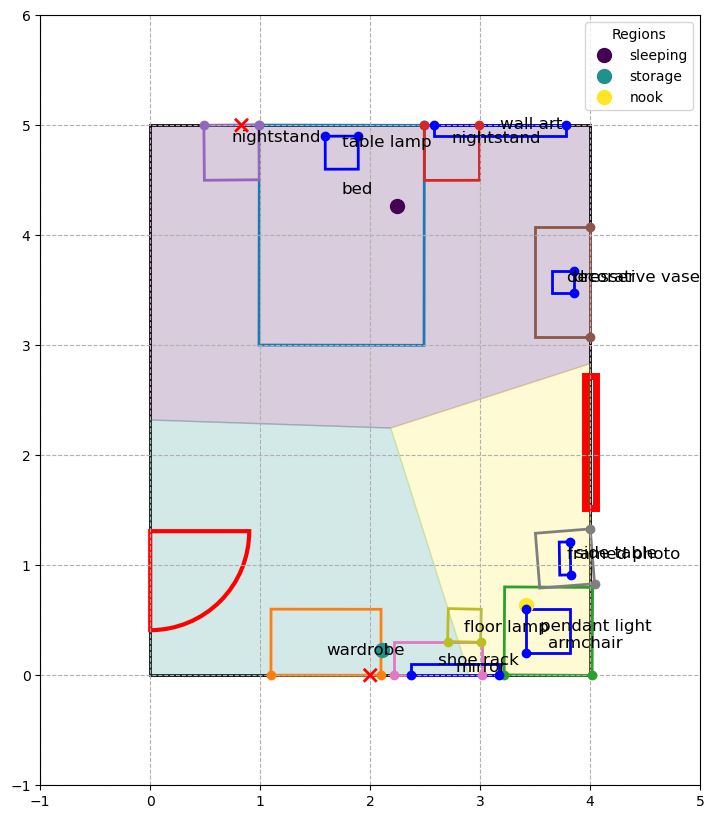

In [226]:
room.draw(draw_regions = True) # uncomment for all objects and regions
#room.draw(level = 0, arrows = True, key = True) # uncomment for primary + secondary objects labelled
#room.draw(level = 1, arrows = True, key = True) # uncomment for tertiary objects labelled

## Metric Evaluation

The Object Overlap Rate (OOR) is:  0.0062766688077708545
The Out-Of-Bounds Rate (OOB) is:  0.14070713895382675


/Users/gabriellelittlefair/Documents/Github/MSc-Project/Scene_Synthesis/Metrics.py:260: RuntimeWarning: invalid value encountered in divide
  direction = direction / np.linalg.norm(direction)


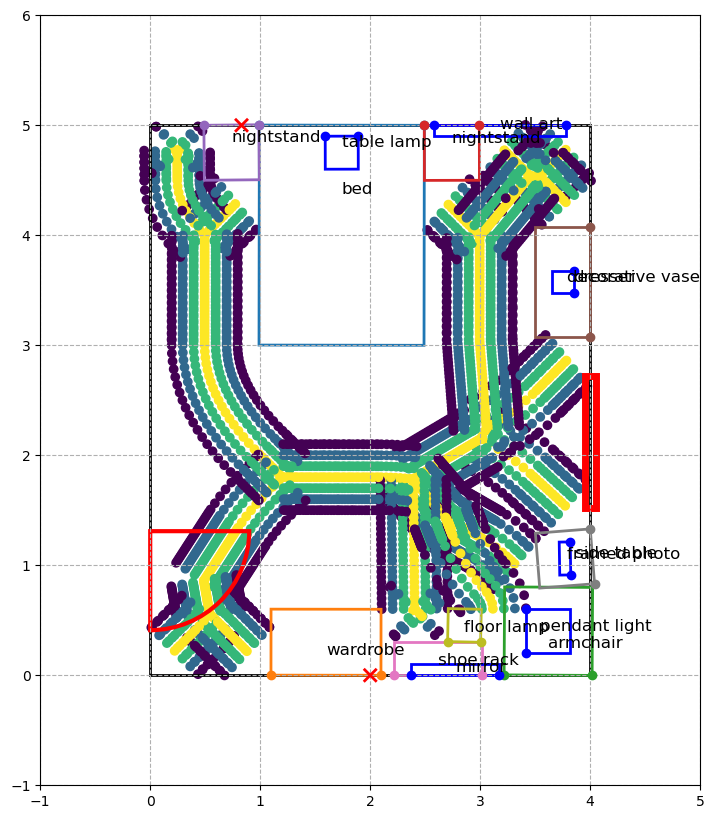

The Pathway Cost (C_p) is:  0.10527722801008603


In [227]:
print("The Object Overlap Rate (OOR) is: ", OOR(room))
print("The Out-Of-Bounds Rate (OOB) is: ", OOB(room))
print("The Pathway Cost (C_p) is: ", pathway_cost(room))